Notebook to compare HYCOM and NOAA

In [2]:
import grab_HYCOM
import netCDF4 as nc

import matplotlib.pyplot as plt

from nowcast import analyze, residuals, figures
from nowcast.workers import get_NeahBay_ssh
import datetime
import numpy as np
from dateutil import tz
import seaborn as sns
import pandas as pd

%matplotlib inline

In [3]:
sns.set_style('darkgrid')
config = {'ssh': { 
        'tidal_predictions': '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/tidal_predictions/'
    }}

In [4]:
def HYCOM_forcing_surge(date):
    filename_HY = ('/ocean/nsoontie/MEOPAR/HYCOM/text/{}/'
        'hycom_1934_1661.txt'.format(date.strftime('%Y-%m-%d')))
    data, lon, lot = grab_HYCOM.parse_hycom_text(filename_HY)
    surge_HY = data['ssh']
    dates_HY = []
    for d in data['time']:
        d = d.to_datetime()
        dates_HY.append(d.replace(tzinfo=tz.tzutc()))
    surge_HY, dates_HY = analyze.truncate_data(np.array(surge_HY),np.array(dates_HY), 
                                               date ,date+datetime.timedelta(days=1) )
    return surge_HY, dates_HY

In [5]:
def observed_surge(dates, config, comp_type):
    end = dates[-1]
    if comp_type =='recent':
        obs_prod = 'water_level'
        tide_prod = ''
    elif comp_type =='archived':
        obs_prod = 'hourly_height'
        tide_prod = 'h'
    ttide = figures.get_tides('Neah Bay', config['ssh']['tidal_predictions'])
    res_obs, obs= residuals.obs_residual_ssh_NOAA('Neah Bay', ttide, dates[0], end,product = obs_prod)
    
    return res_obs, np.array(obs.time),

In [6]:
def observed_surge_NOAA(dates, comp_type):
    end = dates[-1]
    if comp_type =='recent':
        obs_prod = 'water_level'
        tide_prod = ''
    elif comp_type =='archived':
        obs_prod = 'hourly_height'
        tide_prod = 'h'
    tides = figures.get_NOAA_tides(figures.SITES['Neah Bay']['stn_no'], 
                                   dates[0].strftime('%d-%b-%Y'), end.strftime('%d-%b-%Y'),
                                   interval=tide_prod)
    obs = figures.get_NOAA_wlevels(figures.SITES['Neah Bay']['stn_no'], 
                                  dates[0].strftime('%d-%b-%Y'), end.strftime('%d-%b-%Y'),
                                  product=obs_prod)
    tides_interp = figures.interp_to_model_time(obs.time, tides.pred, tides.time)

    res = obs.wlev - tides_interp
    return res, obs.time

In [7]:
def plot_orginal(ax, time_HYCOM, ssh_HYCOM, time_NOAA, ssh_NOAA, res_obs, obs_time ):
    ax.plot(time_HYCOM,ssh_HYCOM,'.-',label = 'HYCOM - forecast')
    for run_type in ['forecast', 'nowcast']:
        ax.plot(time_NOAA[run_type],ssh_NOAA[run_type],'.-',label = 'NOAA - {}'.format(run_type))
    ax.plot(obs_time,res_obs,'.-',label = 'Observations', alpha = 0.8)
    #labels etc
    ax.set_ylabel('SSH anomaly [m]')
    ax.legend(loc=0)
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Original data')

In [8]:
def plot_interpolated(ax, time_HYCOM, ssh_HYCOM, time_NOAA, ssh_NOAA, res_obs, obs_time):
    interp_NOAA={}
    for run_type in ['nowcast', 'forecast']:
        interp_NOAA[run_type] = figures.interp_to_model_time(time_HYCOM,
                                                             ssh_NOAA[run_type], time_NOAA[run_type])
    interp_obs = figures.interp_to_model_time(time_HYCOM, res_obs, obs_time)
    ax.plot(time_HYCOM,ssh_HYCOM,'.-',label = 'HYCOM - forecast')
    for run_type in ['forecast', 'nowcast']:
        ax.plot(time_HYCOM,interp_NOAA[run_type],'.-',label = 'NOAA - {}'.format(run_type))
    ax.plot(time_HYCOM,interp_obs,'.-',label = 'Observations',alpha = 0.8)
    #labels etc
    ax.set_ylabel('SSH anomaly [m]')
    ax.legend(loc=0)
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Interoplated to HYCOM times')
    return interp_NOAA, interp_obs

In [9]:
def plot_errors(ax,time_HYCOM, ssh_HYCOM, interp_NOAA, interp_obs ):
    NOAA_error = np.array(interp_obs)- np.array(interp_NOAA['forecast'])
    HYCOM_error = np.array(interp_obs) - np.array(ssh_HYCOM)
    ax.plot(time_HYCOM,HYCOM_error,'.-',label = 'HYCOM - forecast')
    ax.plot(time_HYCOM,NOAA_error,'.-',label = 'NOAA - forecast')
    #labels etc
    ax.set_ylabel('Error [m]')
    ax.legend(loc=0)
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Error (obs-model)')
    return NOAA_error, HYCOM_error

In [10]:
def compare_HYCOM_NOAA(dates, comp_type='recent'):
    """ 
    Compares the HYCMO and NOAA ssh anomaly forecasts for a dates in date.
    Observations are also plotted"""
    
    fig, axs = plt.subplots(3,1,figsize = (10,10))
    
    ssh_NOAA = {'nowcast': np.array([]),
                'forecast': np.array([])}
    time_NOAA = {'nowcast': np.array([]),
                 'forecast': np.array([])}
    ssh_HYCOM = np.array([]); time_HYCOM = np.array([])
    
    for date in dates:
        # get NOAA forecast first
        for run_type in ['nowcast', 'forecast']:
            try:
                filename_NB, run_date = analyze.create_path(run_type, date, 'ssh*.txt')
                dates_NB, surge_NB, _ = residuals.NeahBay_forcing_anom(
                    filename_NB, run_date, config['ssh']['tidal_predictions'])
                surge_NB_trun, dates_NB_trun = analyze.truncate_data(np.array(surge_NB), np.array(dates_NB),
                                                                 date, date + datetime.timedelta(days=1))
                ssh_NOAA[run_type] = np.append(ssh_NOAA[run_type],surge_NB_trun); 
                time_NOAA[run_type] = np.append(time_NOAA[run_type], dates_NB_trun)
            except IOError:
                print('No Salish Sea {} on {}'.format(run_type, date.strftime('%Y-%m-%d')))
            
        # now get HYCOM
        try:
            surge_HY, dates_HY = HYCOM_forcing_surge(date)
            ssh_HYCOM= np.append(ssh_HYCOM,surge_HY)
            time_HYCOM = np.append(time_HYCOM, dates_HY)
        except IOError:
            print('HYCOM missing date {}'.format(date.strftime('%d-%b-%Y')) )
    
    #observations
    res_obs, obs_time = observed_surge(dates, config, comp_type)
    
    #plotting
    ax=axs[0]
    plot_orginal(ax, time_HYCOM, ssh_HYCOM, time_NOAA, ssh_NOAA, res_obs, obs_time )
    
    #interpolate NOAA and obs to HYCOM times
    ax=axs[1]
    interp_NOAA, interp_obs = plot_interpolated(ax, time_HYCOM, ssh_HYCOM, time_NOAA, ssh_NOAA,
                                                res_obs, obs_time)
    
    # Errors
    #plotting
    ax=axs[2]
    NOAA_error, HYCOM_error = plot_errors(ax,time_HYCOM, ssh_HYCOM, interp_NOAA, interp_obs )

    #analysis of error
    fig2, axs = plt.subplots(1,2,figsize=(10,3))
    errors = [ HYCOM_error, NOAA_error,]
    ax=axs[0]
    ax.boxplot(errors, labels=[ 'HYCOM - forecast','NOAA - forecast'])
    ax.set_title('Errors')
    ax.legend(loc=0)
    ax=axs[1]
    abs_errors = [ np.abs(HYCOM_error),np.abs(NOAA_error),]
    ax.boxplot(abs_errors, labels=[ 'HYCOM - forecast','NOAA - forecast'])
    ax.set_title('Absolute Errors')
    ax.legend(loc=0)
    
    return fig, fig2

Note, I can only downlaoad 1 month of 6 minute NOAA data at a time. 

Also, hourly data isn't available right away because it needs to be verified. I have found that last week's hourly data is usually available, but not yesterday's or the day before. 

In [11]:
start  = datetime.datetime(2015,12,4); start = start.replace(tzinfo=tz.tzutc())
end = datetime.datetime(2016,1,3); end = end.replace(tzinfo=tz.tzutc())
numdays = (end-start).total_seconds()/86400
dates = [start + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]
print(dates[-1])

2016-01-03 00:00:00+00:00


HYCOM doesn't have the first time point but this may be an artifact of parsing.


# Latest water levels
Comparison with very recent prelimnary water levels from NOAA. Typcailly, we can only download one month of this data

No Salish Sea nowcast on 2015-12-15
No Salish Sea forecast on 2015-12-16


/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


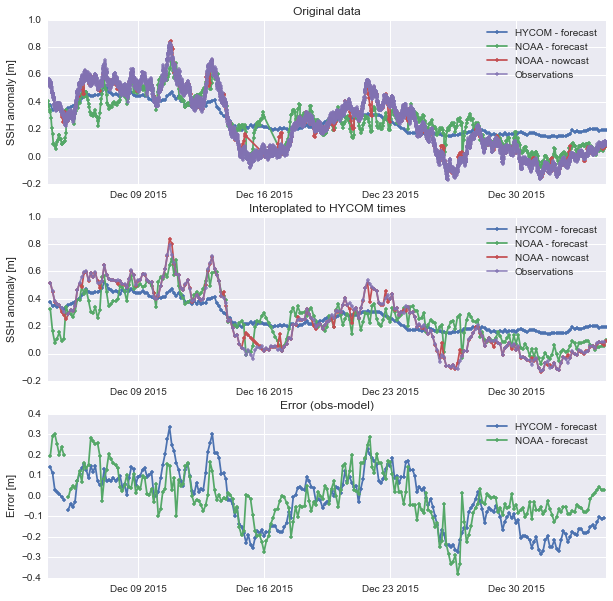

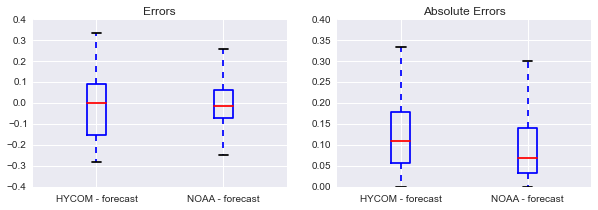

In [12]:
fig, fig2 = compare_HYCOM_NOAA(dates)

Every day there is a peak in forcing residual and in the observed residual. I think this is because my tides are missing some diurnal energy.

# Verfied water levels
Less recent, lower frequency data. Typically, many months are available the latest two weeks or so are not. 

HYCOM missing date 31-Jul-2015
HYCOM missing date 13-Sep-2015
HYCOM missing date 03-Nov-2015
No Salish Sea forecast on 2015-11-30
No Salish Sea nowcast on 2015-12-15
No Salish Sea forecast on 2015-12-16


/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


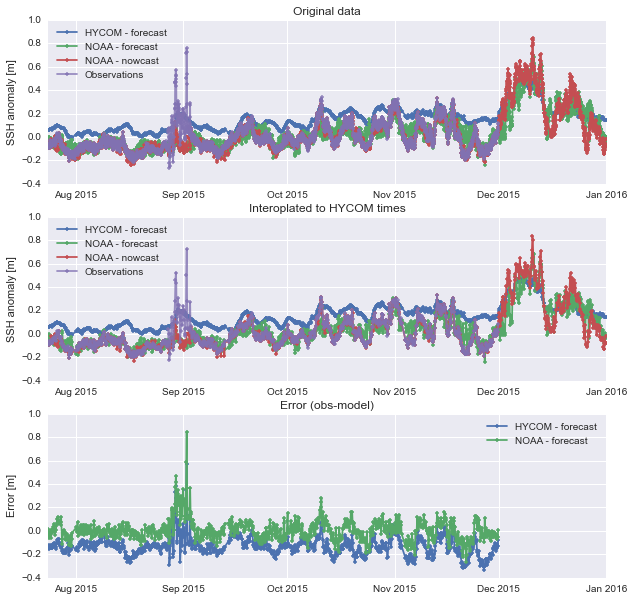

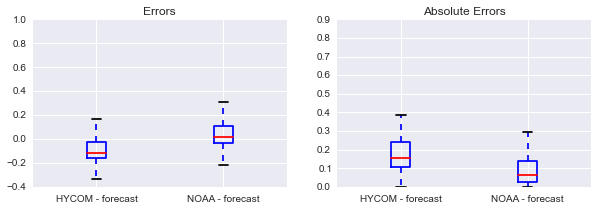

In [13]:

start  = datetime.datetime(2015,7,24); start = start.replace(tzinfo=tz.tzutc())
end = datetime.datetime(2015,12,31); end = end.replace(tzinfo=tz.tzutc())
numdays = (end-start).total_seconds()/86400
dates = [start + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

fig, fig2 = compare_HYCOM_NOAA(dates, comp_type='archived')